In [1]:
import pyodbc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

In [2]:
conn_str = (
    "DRIVER={ODBC Driver 18 for SQL Server};"
    "SERVER=localhost;"               # default instance
    "DATABASE=DW_Education;"
    "Trusted_Connection=yes;"
    "TrustServerCertificate=yes;"
)

conn = pyodbc.connect(conn_str)
if conn:
    print("Connected successfully")

Connected successfully


In [3]:
query = """
SELECT
    f.IPS,
    f."Taux de réussite" AS Taux_Reussite,
    f."Taux de mentions" AS Taux_Mentions,
    f.Nb_eleves,

    -- Geographic info
    g.Code_postal AS Code_Postal,
    g.Nom_commune AS Ville,
    g.Libelle_region AS Region,

    -- Etablissement info
    e.UAI AS UAI,
    e.Nom_etablissement AS Nom_Etablissement,
    e.Statut_public_prive AS Statut_Etablissement,

    -- Date info
    d.Annee,
    d.Mois,
    d.Jour,

    -- Section info
    s.Code_Section,

    -- Voie info
    v.Code_Voie,

    -- Type Etablissement info
    t.Code_TypeEtab,

    -- Service info
    srv.Code_Service

FROM dbo.factEtablissement2 AS f

-- Join each dimension
LEFT JOIN dbo.dim_geographie AS g
    ON f.Geographie_FK = g.Geographie_PK

LEFT JOIN dbo.dim_etablissment AS e
    ON f.Etablissment_FK = e.Etablissment_PK

LEFT JOIN dbo.dim_Date AS d
    ON f.Date_FK = d.Date_PK

LEFT JOIN dbo.dim_Section AS s
    ON f.Section_FK = s.Section_PK

LEFT JOIN dbo.dim_Voie AS v
    ON f.Voie_FK = v.Voie_PK

LEFT JOIN dbo.dim_TypeEtablissement AS t
    ON f.TypeEtab_FK = t.TypeEtab_PK

LEFT JOIN dbo.dim_Service AS srv
    ON f.Service_FK = srv.Service_PK;

"""

df = pd.read_sql(query, conn)
df.head()

C:\Users\mk\AppData\Local\Temp\ipykernel_7832\2984369686.py:61: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,IPS,Taux_Reussite,Taux_Mentions,Nb_eleves,Code_Postal,Ville,Region,UAI,Nom_Etablissement,Statut_Etablissement,Annee,Mois,Jour,Code_Section,Code_Voie,Code_TypeEtab,Code_Service
0,118.3,99,59.0,690.0,25000,Besançon,Bourgogne-Franche-Comté,0251028G,Lycée général et technologique privé Saint-Jean,Privé,1967.0,3.0,30.0,SPO,G,L,APP
1,118.3,99,59.0,690.0,25000,Besançon,Bourgogne-Franche-Comté,0251028G,Lycée général et technologique privé Saint-Jean,Privé,1967.0,3.0,30.0,SPO,T,L,APP
2,118.3,99,59.0,690.0,25000,Besançon,Bourgogne-Franche-Comté,0251028G,Lycée général et technologique privé Saint-Jean,Privé,1967.0,3.0,30.0,EUR,G,L,APP
3,118.3,99,59.0,690.0,25000,Besançon,Bourgogne-Franche-Comté,0251028G,Lycée général et technologique privé Saint-Jean,Privé,1967.0,3.0,30.0,EUR,T,L,APP
4,118.3,99,59.0,690.0,25000,Besançon,Bourgogne-Franche-Comté,0251028G,Lycée général et technologique privé Saint-Jean,Privé,1967.0,3.0,30.0,ART,G,L,APP


In [4]:
# -----------------------------
# INITIAL INSPECTION
# -----------------------------
print(df.head())
print(df.info())
print(df.describe())

     IPS Taux_Reussite  Taux_Mentions  Nb_eleves Code_Postal     Ville  \
0  118.3            99           59.0      690.0       25000  Besançon   
1  118.3            99           59.0      690.0       25000  Besançon   
2  118.3            99           59.0      690.0       25000  Besançon   
3  118.3            99           59.0      690.0       25000  Besançon   
4  118.3            99           59.0      690.0       25000  Besançon   

                    Region       UAI  \
0  Bourgogne-Franche-Comté  0251028G   
1  Bourgogne-Franche-Comté  0251028G   
2  Bourgogne-Franche-Comté  0251028G   
3  Bourgogne-Franche-Comté  0251028G   
4  Bourgogne-Franche-Comté  0251028G   

                                 Nom_Etablissement Statut_Etablissement  \
0  Lycée général et technologique privé Saint-Jean                Privé   
1  Lycée général et technologique privé Saint-Jean                Privé   
2  Lycée général et technologique privé Saint-Jean                Privé   
3  Lycée génér

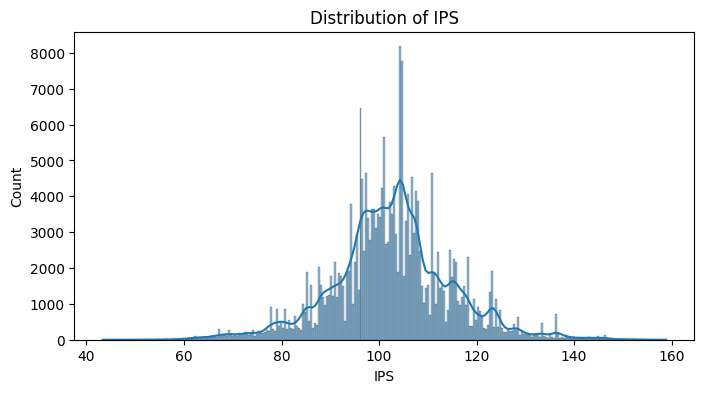

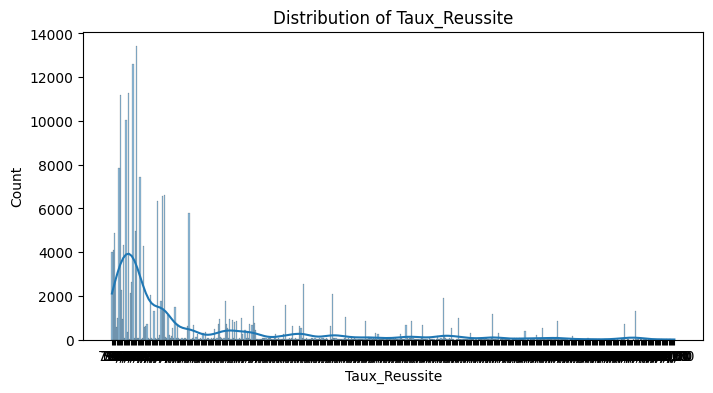

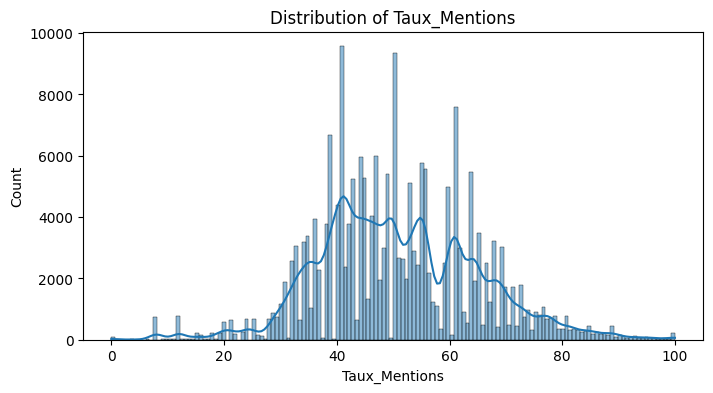

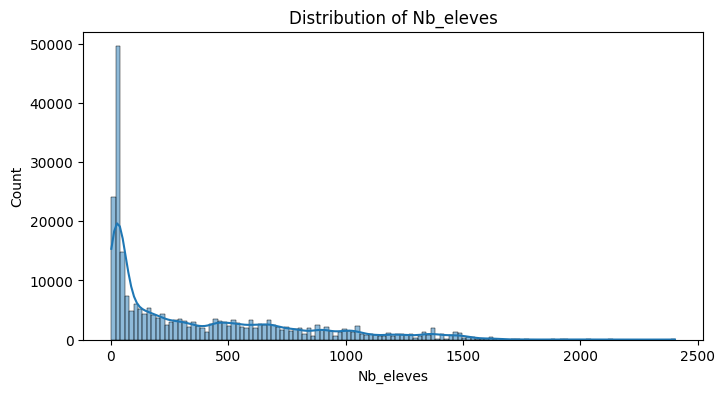

In [5]:
# -----------------------------
# NUMERIC DISTRIBUTIONS
# -----------------------------
numeric_cols = ["IPS", "Taux_Reussite", "Taux_Mentions", "Nb_eleves"]


for col in numeric_cols:
    plt.figure(figsize=(8,4))
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

In [6]:
#!pip install ipywidgets

In [ ]:
from ydata_profiling import ProfileReport

# Créer le rapport
profile = ProfileReport(df, title="Data Profiling Report", explorative=True)

# Afficher directement dans Colab
profile.to_notebook_iframe()

In [ ]:
# -----------------------------
# OUTLIER DETECTION (IQR METHOD)
# -----------------------------
def remove_outliers_iqr(data, cols):
    cleaned = data.copy()
    for col in cols:
        Q1 = cleaned[col].quantile(0.25)
        Q3 = cleaned[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        cleaned = cleaned[(cleaned[col] >= lower) & (cleaned[col] <= upper)]
    return cleaned

In [ ]:
df['Taux_Reussite'] = pd.to_numeric(df['Taux_Reussite'], errors='coerce')

In [ ]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(numeric_cols)

['IPS', 'Taux_Reussite', 'Taux_Mentions', 'Nb_eleves', 'Annee', 'Mois', 'Jour']


In [ ]:
df.describe()


,IPS,Taux_Reussite,Taux_Mentions,Nb_eleves,Annee,Mois,Jour
count,232708.000000,132979.000000,204203.00000,252669.000000,245500.000000,245500.000000,245500.000000
mean,102.615825,90.785553,50.84542,374.252061,1972.764342,6.245939,6.203026
std,12.208354,6.145538,14.13976,413.382941,12.909126,2.514513,8.461031
min,43.300000,51.000000,0.00000,2.000000,1950.000000,1.000000,1.000000
25%,96.100000,88.000000,41.00000,25.000000,1965.000000,5.000000,1.000000
50%,102.600000,91.000000,50.00000,196.000000,1966.000000,5.000000,1.000000
75%,108.700000,95.000000,61.00000,624.000000,1975.000000,9.000000,10.000000
max,158.900000,100.000000,100.00000,2403.000000,2019.000000,12.000000,31.000000


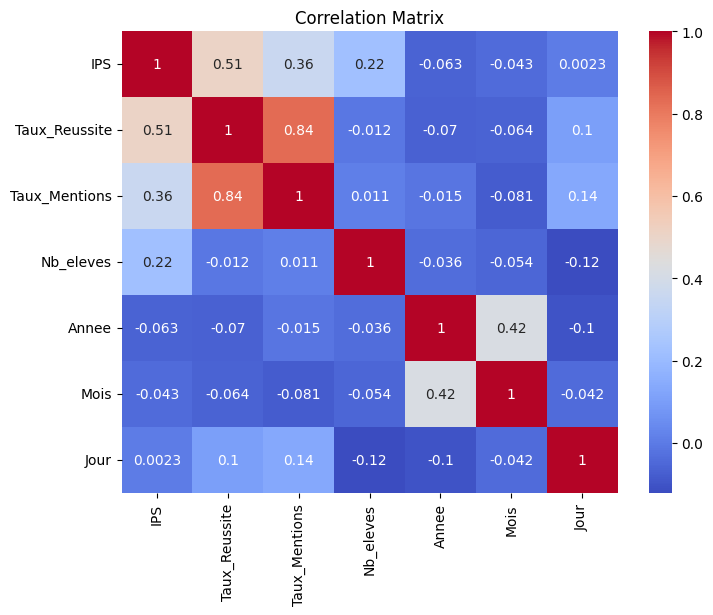

In [ ]:
# -----------------------------
# CORRELATION MATRIX
# -----------------------------
plt.figure(figsize=(8,6))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

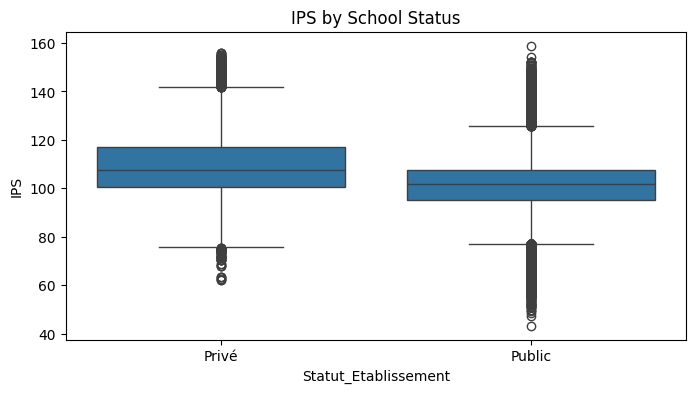

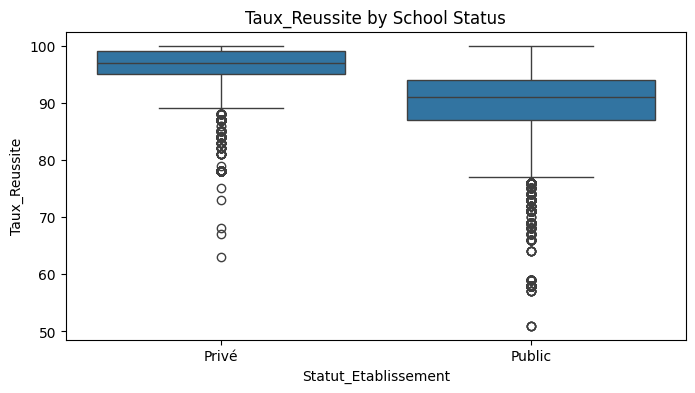

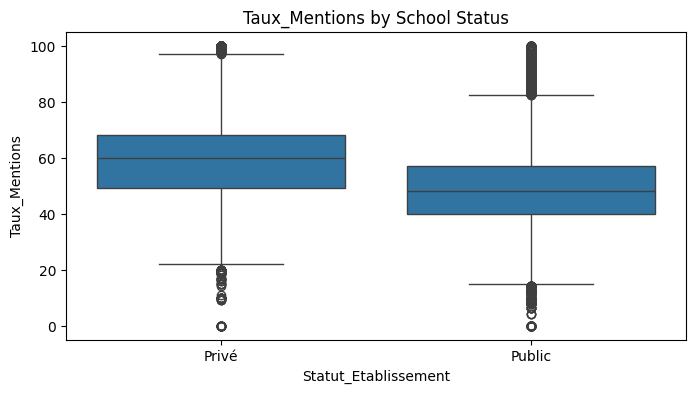

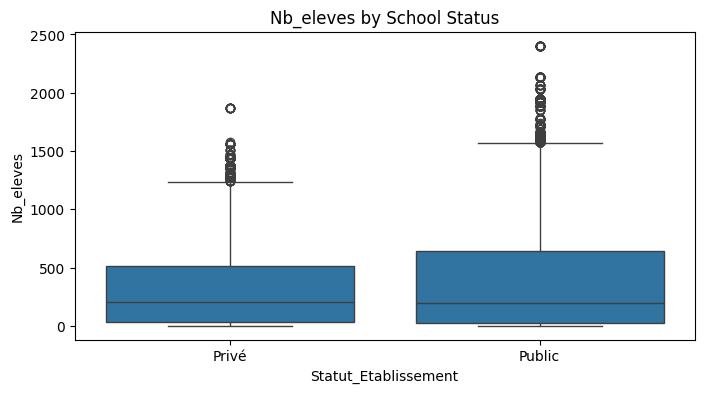

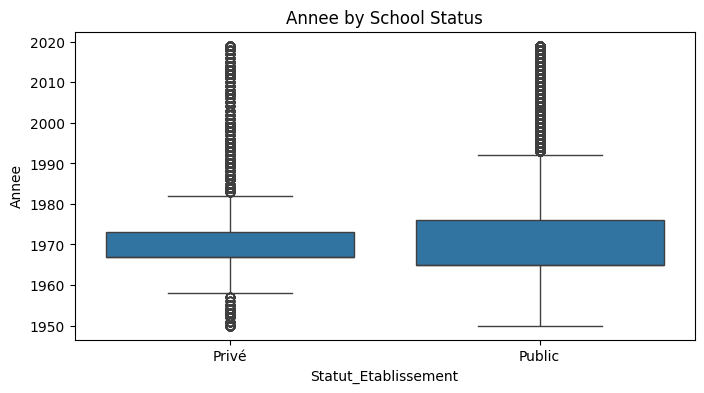

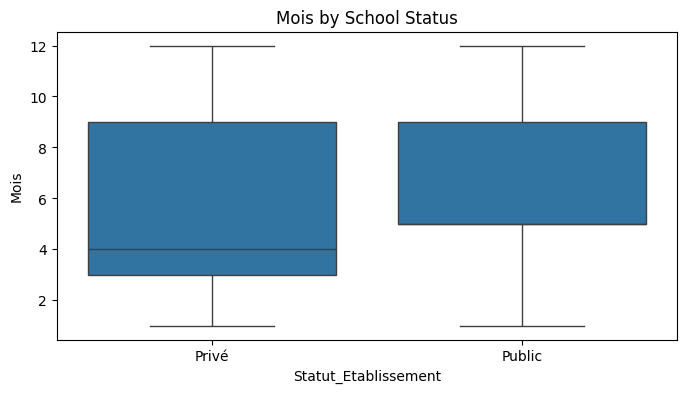

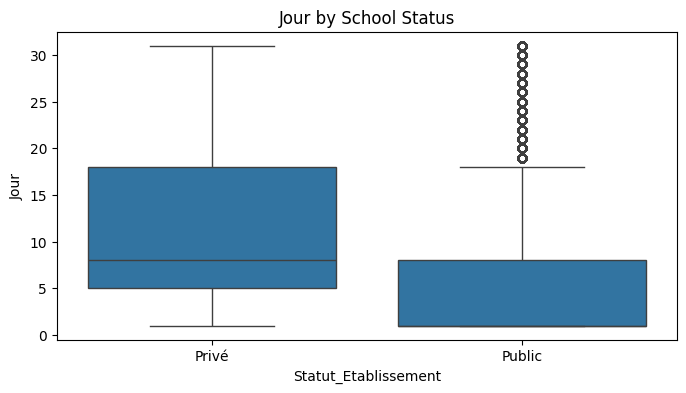

In [ ]:
# -----------------------------
# BOXPLOTS BY SCHOOL STATUS
# -----------------------------
for col in numeric_cols:
    plt.figure(figsize=(8,4))
    sns.boxplot(data=df, x="Statut_Etablissement", y=col)
    plt.title(f"{col} by School Status")
    plt.show()

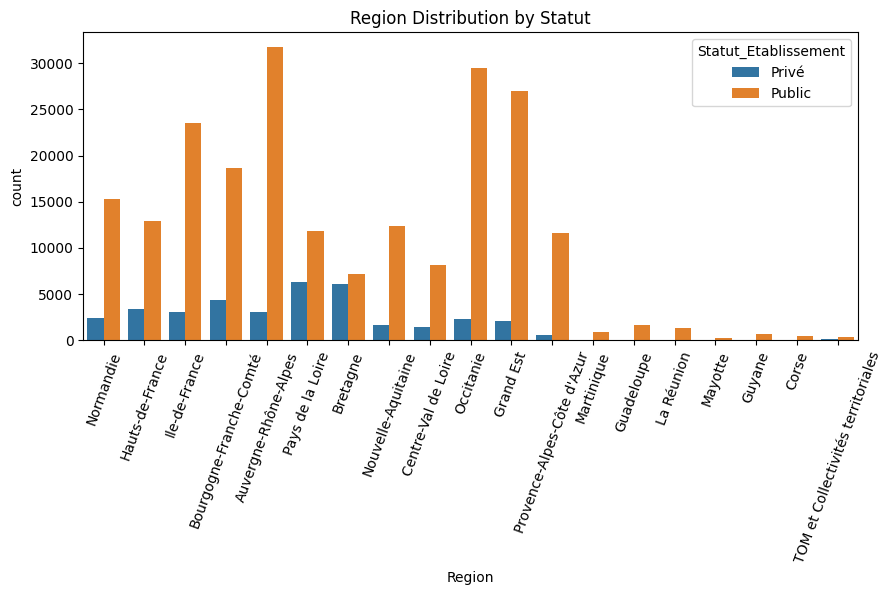

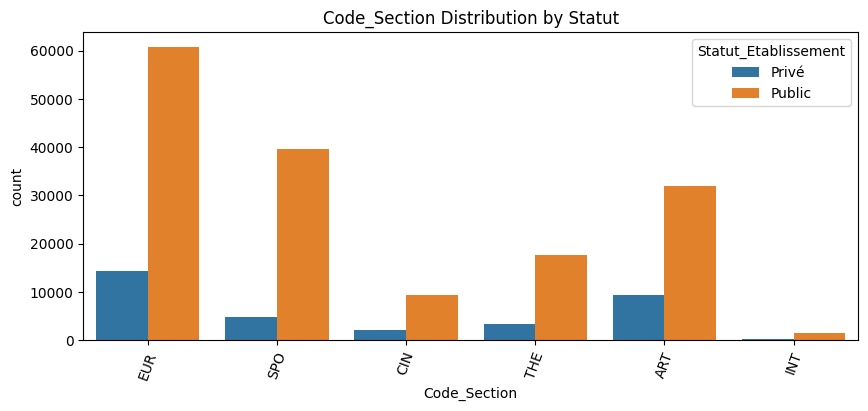

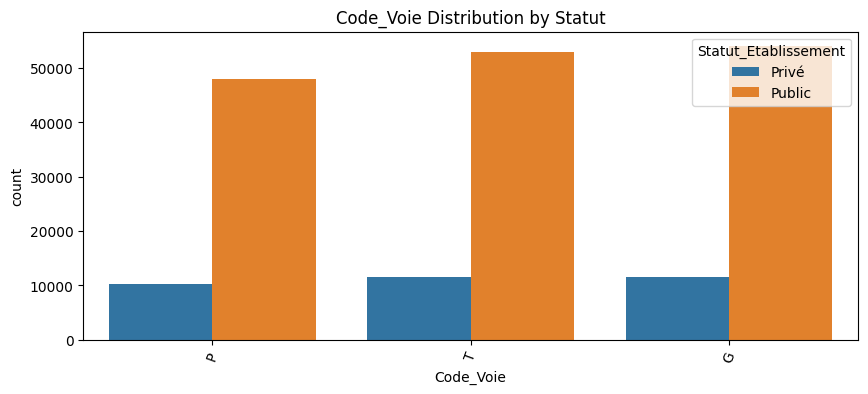

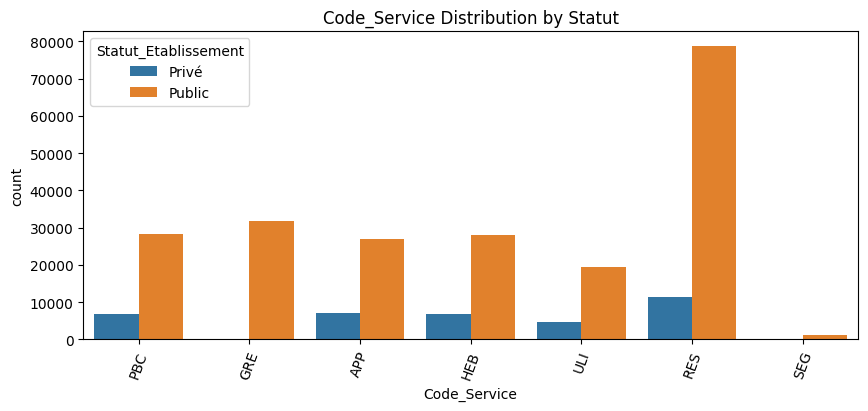

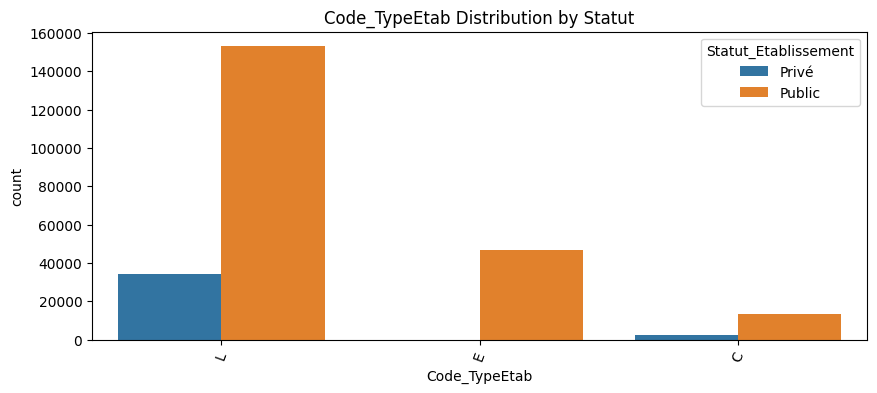

In [ ]:
# -----------------------------
# CATEGORICAL PLOTS
# -----------------------------
cat_cols = ["Region", "Code_Section", "Code_Voie", "Code_Service", "Code_TypeEtab"]


for col in cat_cols:
    plt.figure(figsize=(10,4))
    sns.countplot(data=df, x=col, hue="Statut_Etablissement")
    plt.xticks(rotation=70)
    plt.title(f"{col} Distribution by Statut")
    plt.show()

In [ ]:
numeric_cols = ['IPS', 'Taux_Reussite', 'Taux_Mentions', 'Nb_eleves','Annee']
categorical_cols = ['Region', 'Code_Section', 'Code_Voie', 'Code_Service', 'Code_TypeEtab','Statut_Etablissement']

df["Nb_eleves"]= df["Nb_eleves"].fillna(df["Nb_eleves"].median())
df["Taux_Reussite"]= df["Taux_Reussite"].fillna(df["Taux_Reussite"].median())
df["Taux_Mentions"]= df["Taux_Mentions"].fillna(df["Taux_Mentions"].mean())
df["IPS"]= df["IPS"].fillna(df["IPS"].mean())
df["Annee"]= df["Annee"].fillna(df["Annee"].median())


for col in categorical_cols:
    mode_val = df[col].mode()[0]  # most frequent value
    df[col] = df[col].fillna(mode_val)



In [ ]:
df.shape

(252669, 17)

In [ ]:
df_grouped = df.groupby('UAI').agg({
    'IPS': 'median',                   # numeric
    'Taux_Reussite': 'median',         # numeric
    'Taux_Mentions': 'median',         # numeric
    'Nb_eleves': 'first',                # total students
    'Region': lambda x: x.mode()[0],   # most common region
    'Code_TypeEtab': lambda x: x.mode()[0],  # most common type
    'Code_Section': lambda x: ','.join(sorted(set(x.dropna()))),
    'Code_Service': lambda x: ','.join(sorted(set(x.dropna()))),
    'Code_Voie': lambda x: ','.join(sorted(set(x.dropna()))),
    'Statut_Etablissement': 'first',  # keep the target

}).reset_index()

In [ ]:
df_grouped.shape

(51361, 11)

In [ ]:
print("Original size:", df_grouped.shape)
cols_for_outlier_removal = ['IPS','Nb_eleves']
df_grouped = remove_outliers_iqr(df_grouped,cols_for_outlier_removal )
print("After outlier removal:", df_grouped.shape)

Original size: (51361, 11)
After outlier removal: (39528, 11)


In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

# Sections
df_grouped['Section_list'] = df_grouped['Code_Section'].str.split(',')
mlb_sec = MultiLabelBinarizer()
sec_dummies = pd.DataFrame(mlb_sec.fit_transform(df_grouped['Section_list']),
                           columns=[f"sec_{c}" for c in mlb_sec.classes_],
                           index=df_grouped.index)

# Services
df_grouped['Service_list'] = df_grouped['Code_Service'].str.split(',')
mlb_srv = MultiLabelBinarizer()
srv_dummies = pd.DataFrame(mlb_srv.fit_transform(df_grouped['Service_list']),
                           columns=[f"srv_{c}" for c in mlb_srv.classes_],
                           index=df_grouped.index)

# Voies
df_grouped['Voie_list'] = df_grouped['Code_Voie'].str.split(',')
mlb_voie = MultiLabelBinarizer()
voie_dummies = pd.DataFrame(mlb_voie.fit_transform(df_grouped['Voie_list']),
                            columns=[f"voie_{c}" for c in mlb_voie.classes_],
                            index=df_grouped.index)

df_final = pd.concat([df_grouped, sec_dummies, srv_dummies, voie_dummies], axis=1)


In [ ]:
df_hashable = df_final.applymap(lambda x: tuple(x) if isinstance(x, list) else x)

num_duplicates = df_hashable.duplicated().sum()
print("Number of full duplicate rows:", num_duplicates)

if num_duplicates > 0:
    print(df_hashable[df_hashable.duplicated(keep=False)])

C:\Users\mk\AppData\Local\Temp\ipykernel_50608\526868079.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_hashable = df_final.applymap(lambda x: tuple(x) if isinstance(x, list) else x)


Number of full duplicate rows: 0


In [ ]:
# Check if there are still multiple rows per UAI
duplicates_uai = df_final['UAI'].duplicated().sum()
print("Number of duplicated UAIs:", duplicates_uai)

# Optionally see which UAIs are duplicated
if duplicates_uai > 0:
    print(df_final[df_final['UAI'].duplicated(keep=False)].sort_values('UAI'))

Number of duplicated UAIs: 0


In [ ]:
print("Dataset shape:", df_final.shape)
print("Columns:", df_final.columns.tolist())

Dataset shape: (39528, 30)
Columns: ['UAI', 'IPS', 'Taux_Reussite', 'Taux_Mentions', 'Nb_eleves', 'Region', 'Code_TypeEtab', 'Code_Section', 'Code_Service', 'Code_Voie', 'Statut_Etablissement', 'Section_list', 'Service_list', 'Voie_list', 'sec_ART', 'sec_CIN', 'sec_EUR', 'sec_INT', 'sec_SPO', 'sec_THE', 'srv_APP', 'srv_GRE', 'srv_HEB', 'srv_PBC', 'srv_RES', 'srv_SEG', 'srv_ULI', 'voie_G', 'voie_P', 'voie_T']


In [ ]:
# Make sure Statut_Etablissement is preserved
y =df_grouped["Taux_Mentions"]
# Features: numeric + categorical + multi-hot
numeric_cols = ['IPS', 'Taux_Reussite','Nb_eleves']
categorical_cols = ['Region', 'Code_TypeEtab','Statut_Etablissement']
multi_hot_cols = [col for col in df_final.columns if col.startswith(('sec_', 'srv_', 'voie_'))]

X = df_final[numeric_cols + categorical_cols + multi_hot_cols]

# Drop unnecessary raw columns
cols_to_drop = ['UAI', 'Code_Section', 'Code_Service', 'Code_Voie',
                'Section_list', 'Service_list', 'Voie_list','Taux_Mentions']
X = X.drop(columns=[col for col in cols_to_drop if col in X.columns])

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: (39528, 22)
Target shape: (39528,)


In [ ]:


print(y.value_counts())
y.shape 

Taux_Mentions
50.845420    36540
66.666667       59
50.000000       55
60.000000       48
75.000000       46
             ...  
75.531915        1
76.388889        1
68.888889        1
53.448276        1
14.285714        1
Name: count, Length: 837, dtype: int64


(39528,)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
from sklearn.preprocessing import StandardScaler
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ],
    remainder='passthrough'  # keep multi-hot columns as is
)

In [ ]:
# ---------------------------
# 4) Define base XGBoost regressor

from xgboost import XGBRegressor
xgb_base = XGBRegressor(
    objective='reg:squarederror', 
    random_state=42,
    verbosity=0
)

In [ ]:
from sklearn.multioutput import MultiOutputRegressor
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', xgb_base)
])


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'regressor__n_estimators': [500, 1000],
    'regressor__max_depth': [5, 6, 7],
    'regressor__learning_rate': [0.01, 0.1],
    'regressor__subsample': [0.7, 0.9],
    'regressor__colsample_bytree': [0.7, 0.9],
    'regressor__reg_alpha': [0, 1.0],
    'regressor__reg_lambda': [0, 1.0]
}
# Total: 2 × 3 × 2 × 2 × 2 × 2 × 2 = 384 combinations × 5 folds = 1920 fits ✓

grid_search = GridSearchCV(
    pipeline, param_grid, 
    cv=5, 
    scoring='r2', 
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


,estimator,"Pipeline(step...=None, ...))])"
,param_grid,"{'regressor__colsample_bytree': [0.7, 0.9], 'regressor__learning_rate': [0.01, 0.1], 'regressor__max_depth': [5, 6, ...], 'regressor__n_estimators': [500, 1000], ...}"
,scoring,'r2'
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


In [ ]:
# 1) ADD MORE EVALUATION METRICS
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

print("Best hyperparameters:", grid_search.best_params_)

y_pred = grid_search.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\n=== Model Performance ===")
print(f"R² Score:  {r2:.4f}")
print(f"MSE:       {mse:.4f}")
print(f"RMSE:      {rmse:.4f}")
print(f"MAE:       {mae:.4f}")
print(f"\nMean Taux_Mentions: {y_test.mean():.2f}")  # ← Changed
print(f"Std Taux_Mentions:  {y_test.std():.2f}")  # ← Changed

Best hyperparameters: {'regressor__colsample_bytree': 0.7, 'regressor__learning_rate': 0.01, 'regressor__max_depth': 5, 'regressor__n_estimators': 500, 'regressor__reg_alpha': 1.0, 'regressor__reg_lambda': 1.0, 'regressor__subsample': 0.7}

=== Model Performance ===
R² Score:  0.7185
MSE:       9.6766
RMSE:      3.1107
MAE:       0.6481

Mean Taux_Mentions: 51.94
Std Taux_Mentions:  5.86


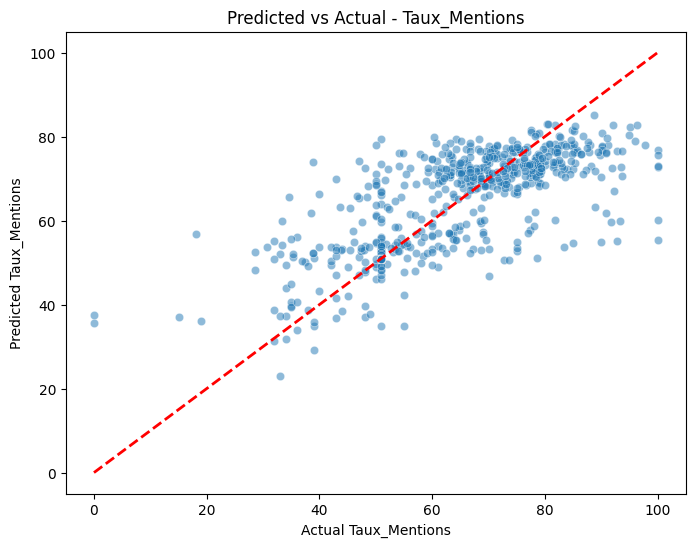

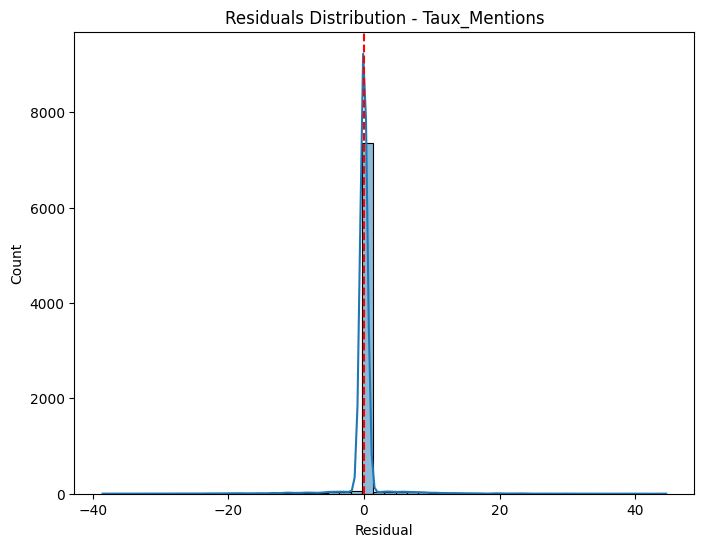

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot: predicted vs actual
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', lw=2)  # perfect prediction line
plt.xlabel("Actual Taux_Mentions")
plt.ylabel("Predicted Taux_Mentions")
plt.title("Predicted vs Actual - Taux_Mentions")
plt.show()

# Residual plot
residuals = y_test - y_pred
plt.figure(figsize=(8,6))
sns.histplot(residuals, bins=50, kde=True)
plt.axvline(0, color='r', linestyle='--')
plt.xlabel("Residual")
plt.title("Residuals Distribution - Taux_Mentions")
plt.show()

In [ ]:
#CHECK FEATURE IMPORTANCE
best_model = grid_search.best_estimator_
feature_names = (numeric_cols + 
                list(best_model.named_steps['preprocessor']
                     .named_transformers_['cat']
                     .get_feature_names_out(categorical_cols)) + 
                multi_hot_cols)
importances = best_model.named_steps['regressor'].feature_importances_

feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

print(feature_importance_df.head(10))


                                      feature  importance
22                            Code_TypeEtab_C    0.431771
23                            Code_TypeEtab_E    0.212875
24                            Code_TypeEtab_L    0.126766
25                 Statut_Etablissement_Privé    0.018317
21  Region_TOM et Collectivités territoriales    0.017696
29                                    sec_EUR    0.017373
33                                    srv_APP    0.013924
26                Statut_Etablissement_Public    0.013732
1                               Taux_Reussite    0.010757
38                                    srv_SEG    0.008544
